In [104]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
import seaborn as sns
mpl.rcParams['figure.figsize'] = (16, 8)
mpl.rcParams['axes.grid'] = False

In [44]:
#Read the csv file
df=pd.read_csv('output.csv', index_col=0, parse_dates=True)
df.head()

,Exchange Rate,Oil price,Gold price,VN Index,S&P500
2012-01-01,21016.5,98.01667,1686.6666,377.63000,1301.9266
2012-01-02,21008.0,97.61000,1747.1000,390.67000,1324.0900
2012-01-03,20845.0,108.84000,1721.1000,427.95000,1374.0900
2012-01-04,20855.0,107.50000,1691.3999,428.23334,1389.9550
2012-01-05,20865.0,106.16000,1661.7000,428.51666,1405.8200


In [45]:
train_dates = df.index
train_dates

DatetimeIndex(['2012-01-01', '2012-01-02', '2012-01-03', '2012-01-04',
               '2012-01-05', '2012-01-06', '2012-01-07', '2012-01-08',
               '2012-01-09', '2012-01-10',
               ...
               '2022-05-22', '2022-05-23', '2022-05-24', '2022-05-25',
               '2022-05-26', '2022-05-27', '2022-05-28', '2022-05-29',
               '2022-05-30', '2022-05-31'],
              dtype='datetime64[ns]', length=3804, freq=None)

In [46]:
cols = list(df)[1:6]
#Date and volume columns are not used in training. 
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']


['Oil price', 'Gold price', 'VN Index', 'S&P500']


In [47]:
df_for_training = df[cols].astype(float)

In [48]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [49]:
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 4)
#12823 refers to the number of data points and 4 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 2])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (3790, 14, 4).
trainY shape == (3790, 1).


In [50]:
trainX

array([[[ 1.34709808,  0.93558905, -1.38886543, -1.3990177 ],
        [ 1.32937754,  1.17694986, -1.34500031, -1.3740615 ],
        [ 1.81872181,  1.07311024, -1.21959451, -1.31776101],
        ...,
        [ 1.12392267,  0.87801158, -1.41069707, -1.33549566],
        [ 1.376874  ,  0.71086973, -1.46724405, -1.41347184],
        [ 1.39877031,  0.73563149, -1.46327473, -1.41218256]],

       [[ 1.32937754,  1.17694986, -1.34500031, -1.3740615 ],
        [ 1.81872181,  1.07311024, -1.21959451, -1.31776101],
        [ 1.76033166,  0.95449305, -1.21864138, -1.29989686],
        ...,
        [ 1.376874  ,  0.71086973, -1.46724405, -1.41347184],
        [ 1.39877031,  0.73563149, -1.46327473, -1.41218256],
        [ 1.42066661,  0.76039324, -1.45930527, -1.41089328]],

       [[ 1.81872181,  1.07311024, -1.21959451, -1.31776101],
        [ 1.76033166,  0.95449305, -1.21864138, -1.29989686],
        [ 1.70194152,  0.83587666, -1.21768832, -1.28203272],
        ...,
        [ 1.39877031,  0.73

In [51]:
trainY

array([[-1.45930527],
       [-1.45533588],
       [-1.45200563],
       ...,
       [ 1.68393563],
       [ 1.6934329 ],
       [ 1.68926168]])

In [52]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 14, 64)            17664     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30,113
Trainable params: 30,113
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
214/214 [==============================] - 7s 17ms/step - loss: 0.0861 - val_loss: 0.2230
Epoch 2/5
214/214 [==============================] - 3s 15ms/step - loss: 0.0469 - val_loss: 0.2263
Epoch 3/5
214/214 [==============================] - 3s 16ms/step - loss: 0.0395 - val_loss: 1.0688
Epoch 4/5
214/214 [==============================] - 3s 15ms/step - loss: 0.0360 - val_loss: 0.1855
Epoch 5/5
214/214 [==============================] - 3s 16ms/step - loss: 0.0341 - val_loss: 0.1104


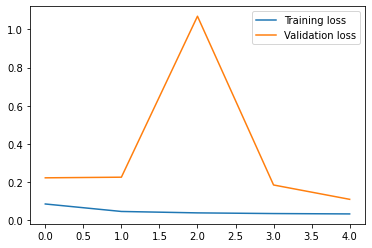

In [53]:
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [99]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 15
n_days_for_prediction=15  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq='D').tolist()
print(predict_period_dates)

[Timestamp('2022-05-17 00:00:00', freq='D'), Timestamp('2022-05-18 00:00:00', freq='D'), Timestamp('2022-05-19 00:00:00', freq='D'), Timestamp('2022-05-20 00:00:00', freq='D'), Timestamp('2022-05-21 00:00:00', freq='D'), Timestamp('2022-05-22 00:00:00', freq='D'), Timestamp('2022-05-23 00:00:00', freq='D'), Timestamp('2022-05-24 00:00:00', freq='D'), Timestamp('2022-05-25 00:00:00', freq='D'), Timestamp('2022-05-26 00:00:00', freq='D'), Timestamp('2022-05-27 00:00:00', freq='D'), Timestamp('2022-05-28 00:00:00', freq='D'), Timestamp('2022-05-29 00:00:00', freq='D'), Timestamp('2022-05-30 00:00:00', freq='D'), Timestamp('2022-05-31 00:00:00', freq='D')]


In [105]:

#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,2]


# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'VN Index_forecast':y_pred_future})
df_forecast.index=pd.to_datetime(np.array(forecast_dates))


df_true = df[['VN Index']]
df_true = df_true.loc[df_true.index >= df_forecast.index.min() - timedelta(days=1)]

# sns.lineplot(original.index, original['VN Index'])
# sns.lineplot(df_forecast.index, df_forecast['VN Index'])


1/1 [==============================] - 0s 43ms/step


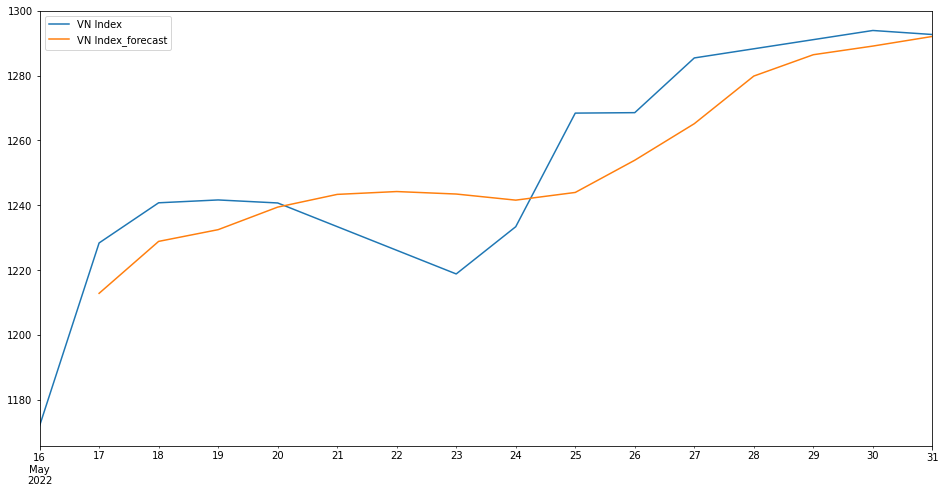

<Figure size 1440x720 with 0 Axes>

In [106]:

df_true['VN Index'].plot(legend=True)
df_forecast['VN Index_forecast'].plot(legend=True)
plt.figure(figsize=(20,10))
plt.show()

In [102]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})



In [91]:
def adjust(val, length= 6): return str(val).ljust(length)

In [103]:
print('\nForecast Accuracy of: VN Index')
accuracy_prod = forecast_accuracy(df_forecast['VN Index_forecast'].values, df_true['VN Index'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))



Forecast Accuracy of: VN Index
mape   :  0.0094
me     :  -3.6595
mae    :  11.7814
mpe    :  -0.0028
rmse   :  13.9358
corr   :  0.8675
minmax :  0.0094


C:\Users\ngthn\AppData\Local\Temp\ipykernel_17036\2139281694.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
C:\Users\ngthn\AppData\Local\Temp\ipykernel_17036\2139281694.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
